# Ablation Study: Notebook

This notebook conducts the training/evaluation
phase of an ablation study for the dual-path kidney classification system. We will train several model variants to analyze the impact of different architectural choices:

- EfficientNet-B4 only (Path A)
- Lightweight CNN only (Path B)
- Dual-path with simple fusion (concatenation)
- Full dual-path with cross-attention (baseline)

All trained models and logs will be saved in the `ablation` folder for later evaluation.

In [1]:
import sys
from pathlib import Path
sys.path.append("/kaggle/input/ablationstudytraining")

In [2]:
# Import Required Libraries
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project modules
from config import *
from models import create_model
from training_pipeline import KidneyTrainer
from dataloader import create_datasets, create_dataloaders
from utils import compute_metrics, thresholded_predictions

In [3]:
# Load and Preprocess Dataset
DATA_DIR = DATA_DIR = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/"

if os.path.exists(DATA_DIR):
    print("Loading datasets...")
    datasets = create_datasets(DATA_DIR)
    dataloaders = create_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
    for split_name, dataset in datasets.items():
        print(f"{split_name}: {len(dataset)} samples")
else:
    print(f"Data directory not found: {DATA_DIR}")
    print("Please update DATA_DIR to point to your dataset")

Loading datasets...
Found class directories: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Cyst: 3709 images
  Normal: 5077 images
  Stone: 1377 images
  Tumor: 2283 images

Total loaded: 12446 images from 4 classes

Data splits:
  train: 8712 samples
    Cyst: 2597
    Normal: 3553
    Stone: 964
    Tumor: 1598
  val: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 206
    Tumor: 343
  test: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 207
    Tumor: 342
train: 8712 samples
val: 1867 samples
test: 1867 samples


In [4]:
# Define Model Variants for Ablation Study
model_variants = {
    'full': {
        'name': 'Full Dual-Path with Cross-Attention',
        'model_type': 'full'
    },
    'efficientnet_only': {
        'name': 'EfficientNet-B4 Only (Path A)',
        'model_type': 'efficientnet_only'
    },
    'cnn_only': {
        'name': 'Lightweight CNN Only (Path B)',
        'model_type': 'cnn_only'
    },
    'simple_fusion': {
        'name': 'Dual-Path with Simple Fusion',
        'model_type': 'simple_fusion'
    }
}

print("Ablation Study Model Variants:")
for key, config in model_variants.items():
    print(f"{key}: {config['name']}")

Ablation Study Model Variants:
full: Full Dual-Path with Cross-Attention
efficientnet_only: EfficientNet-B4 Only (Path A)
cnn_only: Lightweight CNN Only (Path B)
simple_fusion: Dual-Path with Simple Fusion


In [5]:
# os.mkdir("ablation/{key}") 
import os
for key, config in model_variants.items():
    os.makedirs(f"/kaggle/working/ablation/{key}")


In [6]:
# Train Model Variants
trained_models = {}
histories = {}

for key, config in model_variants.items():
    print(f"\nTraining {config['name']}...")
    model = create_model(config['model_type']).to('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = KidneyTrainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        use_freezing=False,
        save_dir=f'ablation/{key}'
    )
    history = trainer.train(num_epochs=TRAINING_CONFIG['num_epochs'])
    trained_models[key] = model
    histories[key] = history
    print(f"Finished training {config['name']}")


Training Full Dual-Path with Cross-Attention...


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Starting training for 50 epochs...
Device: cuda
Model parameters: 19,711,309
Batch 0/544, Loss: 1.4114, Acc: 12.50%
Batch 50/544, Loss: 1.3377, Acc: 39.95%
Batch 100/544, Loss: 0.8820, Acc: 51.73%
Batch 150/544, Loss: 0.2829, Acc: 57.62%
Batch 200/544, Loss: 0.4998, Acc: 63.34%
Batch 250/544, Loss: 0.2033, Acc: 67.36%
Batch 300/544, Loss: 0.1321, Acc: 70.97%
Batch 350/544, Loss: 0.1575, Acc: 74.02%
Batch 400/544, Loss: 0.0585, Acc: 76.34%
Batch 450/544, Loss: 0.0912, Acc: 78.31%
Batch 500/544, Loss: 0.0134, Acc: 80.01%

Epoch 1/50 (394.7s)
Train Loss: 0.4985, Train Acc: 0.8119
Val Loss: 0.0482, Val Acc: 0.9813, Val F1: 0.9749
Learning Rate: 0.000080
Saved best checkpoint with val F1: 0.9749
Batch 0/544, Loss: 0.2451, Acc: 93.75%
Batch 50/544, Loss: 0.1250, Acc: 95.34%
Batch 100/544, Loss: 0.0297, Acc: 95.05%
Batch 150/544, Loss: 0.0081, Acc: 95.28%
Batch 200/544, Loss: 0.0153, Acc: 95.90%
Batch 250/544, Loss: 0.0058, Acc: 95.92%
Batch 300/544, Loss: 0.0052, Acc: 96.03%
Batch 350/544, L

In [7]:
# Save Trained Models to 'ablation' Folder
import torch
import pickle

for key, model in trained_models.items():
    model_path = f'/kaggle/working/ablation/{key}/{key}_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Saved model: {model_path}")
    # Save training history
    history_path = f'/kaggle/working/ablation/{key}/{key}_history.pkl'
    with open(history_path, 'wb') as f:
        pickle.dump(histories[key], f)
    print(f"Saved training history: {history_path}")

Saved model: /kaggle/working/ablation/full/full_model.pth
Saved training history: /kaggle/working/ablation/full/full_history.pkl
Saved model: /kaggle/working/ablation/efficientnet_only/efficientnet_only_model.pth
Saved training history: /kaggle/working/ablation/efficientnet_only/efficientnet_only_history.pkl
Saved model: /kaggle/working/ablation/cnn_only/cnn_only_model.pth
Saved training history: /kaggle/working/ablation/cnn_only/cnn_only_history.pkl
Saved model: /kaggle/working/ablation/simple_fusion/simple_fusion_model.pth
Saved training history: /kaggle/working/ablation/simple_fusion/simple_fusion_history.pkl


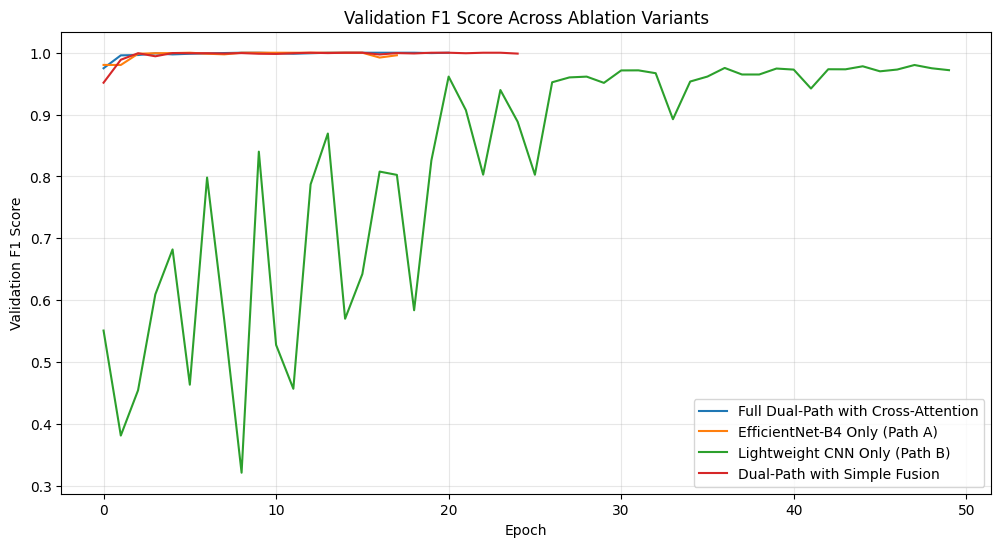

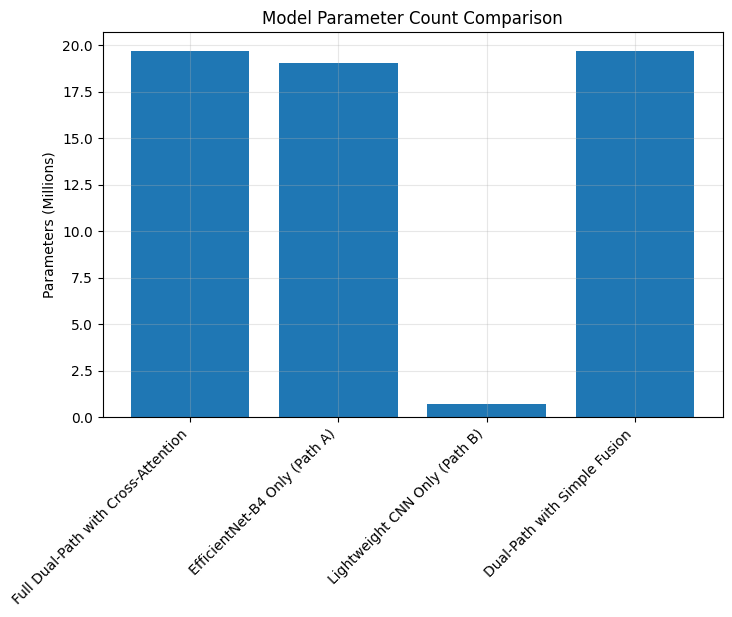

In [8]:
# Visualize Training Curves and Parameter Counts
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for key, history in histories.items():
    plt.plot(history['val_f1'], label=model_variants[key]['name'])
plt.xlabel('Epoch')
plt.ylabel('Validation F1 Score')
plt.title('Validation F1 Score Across Ablation Variants')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Parameter count comparison
param_counts = {key: sum(p.numel() for p in trained_models[key].parameters()) for key in trained_models}
plt.figure(figsize=(8, 5))
plt.bar([model_variants[k]['name'] for k in param_counts], [v/1e6 for v in param_counts.values()])
plt.ylabel('Parameters (Millions)')
plt.title('Model Parameter Count Comparison')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Import Required Libraries
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project modules
from config import *
from models import create_model
from utils import compute_metrics, thresholded_predictions
from dataloader import create_datasets, create_dataloaders

In [10]:
# Load Trained Models from 'ablation' Folder
model_variants = {
    'full': {
        'name': 'Full Dual-Path with Cross-Attention',
        'model_type': 'full'
    },
    'efficientnet_only': {
        'name': 'EfficientNet-B4 Only (Path A)',
        'model_type': 'efficientnet_only'
    },
    'cnn_only': {
        'name': 'Lightweight CNN Only (Path B)',
        'model_type': 'cnn_only'
    },
    'simple_fusion': {
        'name': 'Dual-Path with Simple Fusion',
        'model_type': 'simple_fusion'
    }
}

loaded_models = {}
for key, config in model_variants.items():
    print(f"Loading {config['name']}...")
    model = create_model(config['model_type']).to('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = f'/kaggle/working/ablation/{key}/{key}_model.pth'
    model.load_state_dict(torch.load(model_path))
    model.eval()
    loaded_models[key] = model
    print(f"Loaded model: {model_path}")

Loading Full Dual-Path with Cross-Attention...
Loaded model: /kaggle/working/ablation/full/full_model.pth
Loading EfficientNet-B4 Only (Path A)...
Loaded model: /kaggle/working/ablation/efficientnet_only/efficientnet_only_model.pth
Loading Lightweight CNN Only (Path B)...
Loaded model: /kaggle/working/ablation/cnn_only/cnn_only_model.pth
Loading Dual-Path with Simple Fusion...
Loaded model: /kaggle/working/ablation/simple_fusion/simple_fusion_model.pth


In [11]:
# Evaluate Model Variants
results = {}
for key, model in loaded_models.items():
    print(f"\nEvaluating {model_variants[key]['name']}...")
    all_targets = []
    all_predictions = []
    all_probabilities = []
    test_loader = dataloaders['test']
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to('cuda' if torch.cuda.is_available() else 'cpu'), targets.to('cuda' if torch.cuda.is_available() else 'cpu')
            logits, confidence = model(images)
            probabilities = torch.softmax(logits, dim=1)
            predicted = thresholded_predictions(probabilities)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    metrics = compute_metrics(
        np.array(all_targets),
        np.array(all_predictions),
        np.array(all_probabilities)
    )
    results[key] = metrics
    print(f"Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['macro_f1']:.4f}")


Evaluating Full Dual-Path with Cross-Attention...
Accuracy: 1.0000, F1: 1.0000

Evaluating EfficientNet-B4 Only (Path A)...
Accuracy: 0.9995, F1: 0.9992

Evaluating Lightweight CNN Only (Path B)...
Accuracy: 0.9764, F1: 0.9678

Evaluating Dual-Path with Simple Fusion...
Accuracy: 0.9984, F1: 0.9982


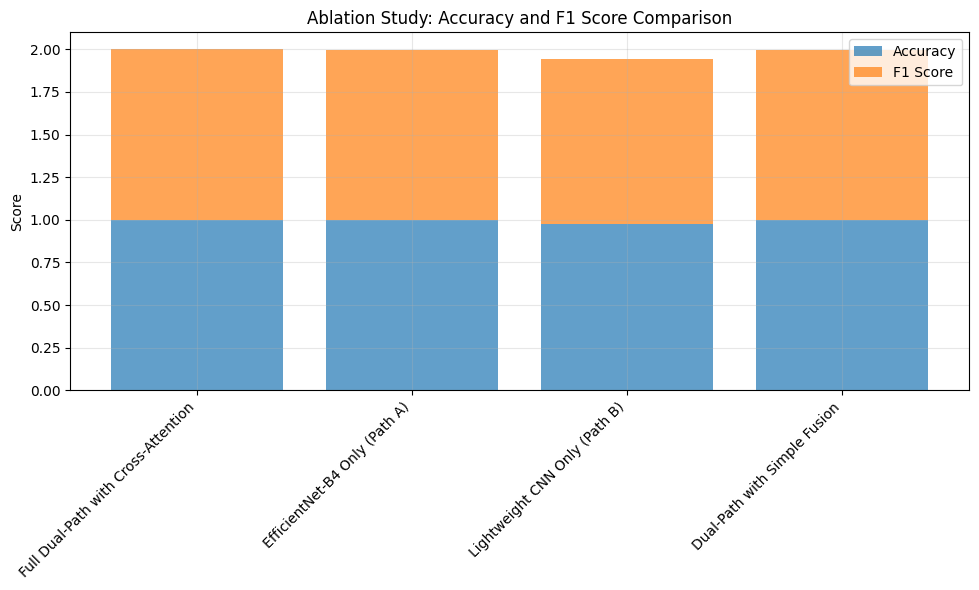

                              Model  Accuracy  F1 Score
Full Dual-Path with Cross-Attention    1.0000    1.0000
      EfficientNet-B4 Only (Path A)    0.9995    0.9992
      Lightweight CNN Only (Path B)    0.9764    0.9678
       Dual-Path with Simple Fusion    0.9984    0.9982


In [12]:
# Compare Evaluation Metrics
import matplotlib.pyplot as plt

model_names = [model_variants[k]['name'] for k in results.keys()]
accuracies = [results[k]['accuracy'] for k in results.keys()]
f1_scores = [results[k]['macro_f1'] for k in results.keys()]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, alpha=0.7, label='Accuracy')
plt.bar(model_names, f1_scores, alpha=0.7, label='F1 Score', bottom=accuracies)
plt.ylabel('Score')
plt.title('Ablation Study: Accuracy and F1 Score Comparison')
plt.xticks(rotation=45, ha='right')
plt.legend(['Accuracy', 'F1 Score'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary table
import pandas as pd
df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})
print(df.to_string(index=False, float_format='%.4f'))

In [13]:
!zip -r ablation_output.zip ablation/

  adding: ablation/ (stored 0%)
  adding: ablation/efficientnet_only/ (stored 0%)
  adding: ablation/efficientnet_only/best_checkpoint.pth (deflated 8%)
  adding: ablation/efficientnet_only/efficientnet_only_history.pkl (deflated 52%)
  adding: ablation/efficientnet_only/latest_checkpoint.pth (deflated 7%)
  adding: ablation/efficientnet_only/efficientnet_only_model.pth (deflated 7%)
  adding: ablation/simple_fusion/ (stored 0%)
  adding: ablation/simple_fusion/best_checkpoint.pth (deflated 8%)
  adding: ablation/simple_fusion/simple_fusion_history.pkl (deflated 53%)
  adding: ablation/simple_fusion/latest_checkpoint.pth (deflated 8%)
  adding: ablation/simple_fusion/simple_fusion_model.pth (deflated 7%)
  adding: ablation/full/ (stored 0%)
  adding: ablation/full/best_checkpoint.pth (deflated 8%)
  adding: ablation/full/full_model.pth (deflated 7%)
  adding: ablation/full/latest_checkpoint.pth (deflated 8%)
  adding: ablation/full/full_history.pkl (deflated 53%)
  adding: ablation/cnn